Import libraries, check your DataFrame

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import sklearn

In [ ]:
new_data = pd.read_csv('/content/wood.csv')
new_data = new_data.drop(columns=new_data.columns[0])

In [ ]:
new_data.describe()

,VOL,AREA_F,APT_NUM,ST_NUM,KREIS,ZIPCODE,YOC,WOOD
count,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000
mean,1512.891608,148.944056,4.695804,4.576923,7.779720,8043.580420,1942.559441,19.328671
std,745.066194,49.875885,2.923909,1.004914,3.102417,15.729027,11.558924,17.405187
min,226.000000,50.000000,1.000000,1.000000,2.000000,8002.000000,1906.000000,0.770000
25%,864.750000,112.250000,1.000000,4.000000,6.000000,8045.000000,1933.000000,6.130000
50%,1582.000000,165.000000,6.000000,5.000000,9.000000,8048.000000,1948.000000,13.770000
75%,1945.000000,176.000000,6.000000,5.000000,11.000000,8052.000000,1950.000000,27.910000
max,3570.000000,274.000000,13.000000,7.000000,12.000000,8057.000000,1972.000000,75.240000


One-hot encode of categorical data


In [ ]:
new_data['KREIS'] = new_data['KREIS'].astype('category')
new_data['ZIPCODE'] = new_data['ZIPCODE'].astype('category')
# One-hot encode the data using pandas get_dummies
new_data = pd.get_dummies(new_data)
print
print(new_data.columns)
print(new_data.shape)

Index(['VOL', 'AREA_F', 'APT_NUM', 'ST_NUM', 'YOC', 'WOOD', 'KREIS_2',
       'KREIS_3', 'KREIS_4', 'KREIS_6', 'KREIS_7', 'KREIS_8', 'KREIS_9',
       'KREIS_10', 'KREIS_11', 'KREIS_12', 'ZIPCODE_8002', 'ZIPCODE_8003',
       'ZIPCODE_8004', 'ZIPCODE_8006', 'ZIPCODE_8008', 'ZIPCODE_8032',
       'ZIPCODE_8038', 'ZIPCODE_8044', 'ZIPCODE_8045', 'ZIPCODE_8046',
       'ZIPCODE_8047', 'ZIPCODE_8048', 'ZIPCODE_8049', 'ZIPCODE_8050',
       'ZIPCODE_8051', 'ZIPCODE_8052', 'ZIPCODE_8053', 'ZIPCODE_8055',
       'ZIPCODE_8057', 'ROOF_F', 'ROOF_M', 'ROOF_O', 'ROOF_P',
       'POC_1900 - 1919', 'POC_1919 - 1945', 'POC_1946 - 1960',
       'POC_1961 - 1970', 'POC_1971 - 1980'],
      dtype='object')
(286, 44)


Split data into an hold-out TEST set (T) and train + validation set (TV)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

material = 'WOOD'

# labels as numpy array
Y=np.array(new_data[material])

#features as numpy array
X_list= new_data.drop(columns=material)
X = np.array(X_list)

#save headers for later
headers = list(X_list.columns)

X_TV, X_T, Y_TV, Y_T = train_test_split(X,Y,test_size = 0.15, random_state = 296) #this split, meaning, this random seed, has to be the same for all the models!

print(X_T, Y_T)

[[1811  189    3 ...    0    0    0]
 [3130  182   10 ...    0    0    0]
 [ 505   70    1 ...    0    0    0]
 ...
 [ 780  112    2 ...    0    1    0]
 [2000  205    9 ...    1    0    0]
 [1685  150    6 ...    0    0    0]] [ 7.96 36.46 21.76  8.77 21.42 36.75 60.38  5.7  30.    3.21 51.52 11.34
  1.3   1.34 41.59  5.12  6.14  2.75  5.7   9.13  6.16 29.59 36.27 19.22
 29.23 13.52 54.28 67.84 22.89  1.32  4.85 15.15 43.29  5.96 10.   23.17
 22.8   1.46  7.   22.23 33.4  25.8  16.01]


Different methods of parameters tuning

RandomizedSearchCV on log-transformed label

In [ ]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline

model_pipe = Pipeline([
('model', TransformedTargetRegressor(regressor=RandomForestRegressor(),
                                     func=np.log, 
                                     inverse_func=np.exp))
])

#Metrics for Evualation:
met_grid= ['r2', 'neg_mean_absolute_error'] #The metric codes from sklearn

# Create the parameter grid based on the results of random search 
params = {
          'model__regressor__max_depth': [3,4,5,7,10,30,None],
          'model__regressor__max_features': ['sqrt',0.3, 0.4, 0.5, 0.6, None, 'log2'],
          'model__regressor__n_estimators': [800, 1000],
          'model__regressor__min_samples_leaf' : [1,2,3,4],
          'model__regressor__bootstrap' : [True, False],
          'model__regressor__min_impurity_decrease' : [0, 0.01, 0.05, 0.1],
          'model__regressor__ccp_alpha' : [0, 0.01, 0.05, 0.1]
      }

# Instantiate the grid search model
grid_search = RandomizedSearchCV(model_pipe, param_distributions = params, scoring = met_grid, refit = 'r2', n_iter = 1000,
                                cv = 10, n_jobs = 1, verbose = 10, return_train_score = True)
# Fit the grid search to the data
grid_search.fit(X_TV, Y_TV)

print(pd.DataFrame(grid_search.cv_results_))
print(grid_search.best_params_)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
[CV 1/10; 1/1000] START model__regressor__bootstrap=False, model__regressor__ccp_alpha=0.05, model__regressor__max_depth=7, model__regressor__max_features=0.4, model__regressor__min_impurity_decrease=0.1, model__regressor__min_samples_leaf=3, model__regressor__n_estimators=1000
[CV 1/10; 1/1000] END model__regressor__bootstrap=False, model__regressor__ccp_alpha=0.05, model__regressor__max_depth=7, model__regressor__max_features=0.4, model__regressor__min_impurity_decrease=0.1, model__regressor__min_samples_leaf=3, model__regressor__n_estimators=1000; neg_mean_absolute_error: (train=-10.300, test=-9.816) r2: (train=0.110, test=-0.014) total time=   1.0s
[CV 2/10; 1/1000] START model__regressor__bootstrap=False, model__regressor__ccp_alpha=0.05, model__regressor__max_depth=7, model__regressor__max_features=0.4, model__regressor__min_impurity_decrease=0.1, model__regressor__min_samples_leaf=3, model__regressor__n_estimator

KeyboardInterrupt: ignored

GridSearchCV on log-transformed label, with reduced max depth to avoid overfitting

In [ ]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline

model_pipe = Pipeline([
('model', TransformedTargetRegressor(regressor=RandomForestRegressor(),
                                     func=np.log, 
                                     inverse_func=np.exp))
])

#Metrics for Evualation:
met_grid= ['r2', 'neg_mean_absolute_error'] #The metric codes from sklearn

# Create the parameter grid based on the results of random search 
params = {
          'model__regressor__max_depth': [10,11,12,13],
          'model__regressor__max_features': ['sqrt', 0.3, 0.5, None],
          'model__regressor__n_estimators': [800],
          'model__regressor__min_samples_leaf' : [1],
          'model__regressor__bootstrap' : [True],
          'model__regressor__min_impurity_decrease' : [0, 0.01],
          'model__regressor__ccp_alpha' : [0, 0.01]
      }

# Instantiate the grid search model
grid_search = GridSearchCV(model_pipe, param_grid = params, scoring = met_grid, refit = 'r2',
                                cv = 10, n_jobs = 1, verbose = 10, return_train_score = True)
# Fit the grid search to the data
grid_search.fit(X_TV, Y_TV)

print(pd.DataFrame(grid_search.cv_results_))
print(grid_search.best_params_)

from google.colab import files

gd_w = pd.DataFrame(grid_search.cv_results_)
gd_w.to_csv('grid_search_w4.csv', encoding = 'utf-8-sig') 
files.download('grid_search_w4.csv')

Fitting 10 folds for each of 64 candidates, totalling 640 fits
[CV 1/10; 1/64] START model__regressor__bootstrap=True, model__regressor__ccp_alpha=0, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_impurity_decrease=0, model__regressor__min_samples_leaf=1, model__regressor__n_estimators=800
[CV 1/10; 1/64] END model__regressor__bootstrap=True, model__regressor__ccp_alpha=0, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_impurity_decrease=0, model__regressor__min_samples_leaf=1, model__regressor__n_estimators=800; neg_mean_absolute_error: (train=-4.045, test=-7.952) r2: (train=0.778, test=0.027) total time=   2.0s
[CV 2/10; 1/64] START model__regressor__bootstrap=True, model__regressor__ccp_alpha=0, model__regressor__max_depth=10, model__regressor__max_features=sqrt, model__regressor__min_impurity_decrease=0, model__regressor__min_samples_leaf=1, model__regressor__n_estimators=800
[CV 2/10; 1/64] END 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Final: GridSearchCV, no log-transform

In [ ]:
rf = RandomForestRegressor()

#Metrics for Evualation:
met_grid= ['r2', 'neg_mean_absolute_error'] #The metric codes from sklearn

# Create the parameter grid based on the results of random search 
params = {
          'max_depth': [7,10,13],
          'max_features': ['sqrt', 0.2, 0.3, 0.5, None],
          'n_estimators': [800],
          'min_samples_leaf' : [1,2,3],
          'bootstrap' : [True],
          'min_impurity_decrease' : [0, 0.01],
          'ccp_alpha' : [0, 0.01]
      }

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = params, scoring = met_grid, refit = 'r2',
                                cv = 10, n_jobs = 1, verbose = 10, return_train_score = True)
# Fit the grid search to the data
grid_search.fit(X_TV, Y_TV)

print(pd.DataFrame(grid_search.cv_results_))
print(grid_search.best_params_)

from google.colab import files

gd_w = pd.DataFrame(grid_search.cv_results_)
gd_w.to_csv('grid_search_w6.csv', encoding = 'utf-8-sig') 
files.download('grid_search_w6.csv')

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
[CV 1/10; 1/180] START bootstrap=True, ccp_alpha=0, max_depth=7, max_features=sqrt, min_impurity_decrease=0, min_samples_leaf=1, n_estimators=800
[CV 1/10; 1/180] END bootstrap=True, ccp_alpha=0, max_depth=7, max_features=sqrt, min_impurity_decrease=0, min_samples_leaf=1, n_estimators=800; neg_mean_absolute_error: (train=-5.813, test=-8.858) r2: (train=0.761, test=0.145) total time=   1.8s
[CV 2/10; 1/180] START bootstrap=True, ccp_alpha=0, max_depth=7, max_features=sqrt, min_impurity_decrease=0, min_samples_leaf=1, n_estimators=800
[CV 2/10; 1/180] END bootstrap=True, ccp_alpha=0, max_depth=7, max_features=sqrt, min_impurity_decrease=0, min_samples_leaf=1, n_estimators=800; neg_mean_absolute_error: (train=-5.969, test=-8.157) r2: (train=0.736, test=0.453) total time=   1.9s
[CV 3/10; 1/180] START bootstrap=True, ccp_alpha=0, max_depth=7, max_features=sqrt, min_impurity_decrease=0, min_samples_leaf=1, n_estimators=800
[CV

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
cv_results_ = pd.read_csv('/content/grid_search_w6.csv')

Read Train + Validation results

Validation r2 score:  0.49 
 Standard deviation:  0.13
Train r2 score:  0.87 
 Standard deviation:  0.01
Validation MAE score:  -7.58 
 Standard deviation:  1.24
Train MAE score:  -4.02 
 Standard deviation:  0.13


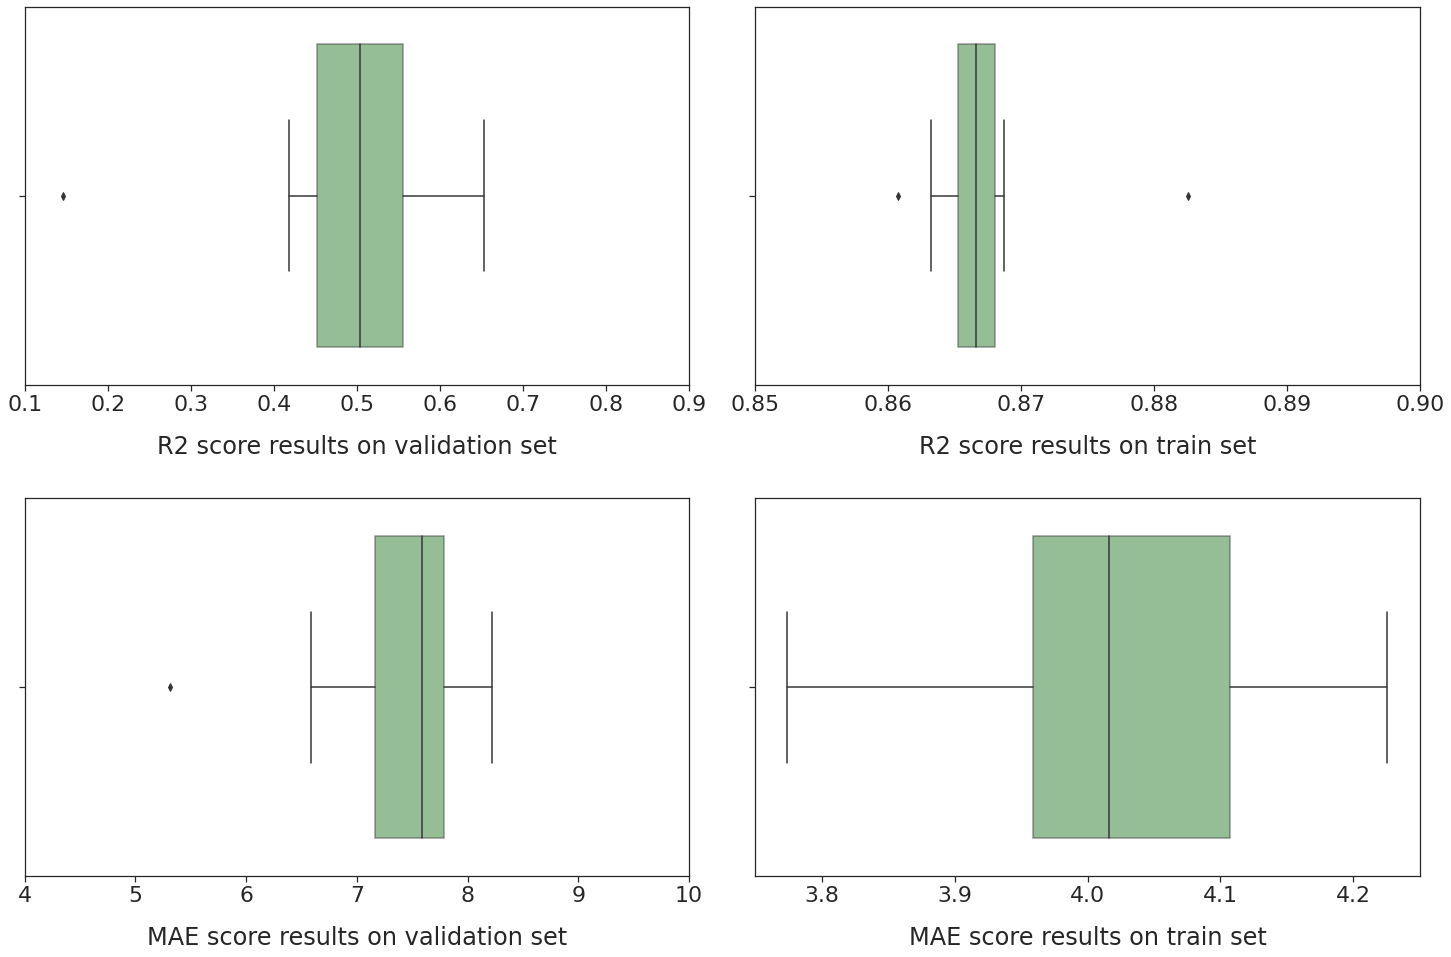

In [ ]:
chosen_index = 33 #grid_search_w6.csv

r2_v = []
mae_v = []
r2_tr = []
mae_tr = []

for i in range (10):
  v_r2 = "split"+str(i)+"_test_r2"  
  v_mae = "split"+str(i)+"_test_neg_mean_absolute_error"
  r2_v.append(cv_results_[v_r2][chosen_index])
  mae_v.append(cv_results_[v_mae][chosen_index]*(-1))

  tr_r2 = "split"+str(i)+"_train_r2"  
  tr_mae = "split"+str(i)+"_train_neg_mean_absolute_error"
  r2_tr.append(cv_results_[tr_r2][chosen_index])
  mae_tr.append(cv_results_[tr_mae][chosen_index]*(-1))

print("Validation r2 score: ", round(cv_results_['mean_test_r2'][chosen_index],2), "\n Standard deviation: ", round(cv_results_['std_test_r2'][chosen_index],2) )
print("Train r2 score: ", round(cv_results_['mean_train_r2'][chosen_index],2),"\n Standard deviation: ", round(cv_results_['std_train_r2'][chosen_index],2))
print("Validation MAE score: ", round(cv_results_['mean_test_neg_mean_absolute_error'][chosen_index],2), "\n Standard deviation: ", round(cv_results_['std_test_neg_mean_absolute_error'][chosen_index],2) )
print("Train MAE score: ", round(cv_results_['mean_train_neg_mean_absolute_error'][chosen_index],2),"\n Standard deviation: ", round(cv_results_['std_train_neg_mean_absolute_error'][chosen_index],2))
metrics_TV = pd.DataFrame(list(zip(r2_v,mae_v,r2_tr,mae_tr)), columns =['r2_validation', 'MAE_validation', 'r2_train', 'MAE_train',])

sns.set(font_scale=2)
f = plt.figure(figsize=(25,16))
gs = f.add_gridspec(2, 2)
gs.update(wspace = 0.1, hspace = 0.3)


with sns.axes_style("ticks"):
    ax = f.add_subplot(gs[0, 0])
    sns.boxplot(data=metrics_TV, x="r2_validation", color = "forestgreen", boxprops=dict(alpha=.5)).set(
    xlabel='R2 score results on validation set')
    ax.xaxis.labelpad = 20
    plt.xlim(0.1, 0.9)


with sns.axes_style("ticks"):
    ax = f.add_subplot(gs[0, 1])
    sns.boxplot(data=metrics_TV, x="r2_train", color = "forestgreen", boxprops=dict(alpha=.5)).set(
    xlabel='R2 score results on train set')
    ax.xaxis.labelpad = 20
    plt.xlim(0.85, 0.9)


with sns.axes_style("ticks"):
    ax = f.add_subplot(gs[1, 0])
    sns.boxplot(data=metrics_TV, x="MAE_validation", color = "forestgreen", boxprops=dict(alpha=.5)).set(
    xlabel='MAE score results on validation set')
    ax.xaxis.labelpad = 20
    plt.xlim(4,10)


with sns.axes_style("ticks"):
    ax = f.add_subplot(gs[1, 1])
    sns.boxplot(data=metrics_TV, x="MAE_train", color = "forestgreen", boxprops=dict(alpha=.5)).set(
    xlabel='MAE score results on train set')
    ax.xaxis.labelpad = 20
    plt.xlim(3.75,4.25)

f.savefig('wood_rf.png')


Hyperparameters applied to (T) set


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

r2=[]
MAE=[]

t_rf = RandomForestRegressor(

    bootstrap = cv_results_['param_bootstrap'][chosen_index],
    n_estimators= cv_results_['param_n_estimators'][chosen_index],
    max_depth = cv_results_['param_max_depth'][chosen_index],
    max_features = cv_results_['param_max_features'][chosen_index],
    min_impurity_decrease = cv_results_['param_min_impurity_decrease'][chosen_index],
    min_samples_leaf = cv_results_['param_min_samples_leaf'][chosen_index],

 )

t_rf.fit(X_TV, Y_TV)

# Get Y predicted
predictions=t_rf.predict(X_T)

# Print out the mean absolute error (mae)
MAE = round(mean_absolute_error(Y_T, predictions),2)
print('Mean Absolute Error:', MAE)

# Print out R2
print('R2:', round(r2_score(Y_T, predictions),2))

Mean Absolute Error: 6.52
R2: 0.64


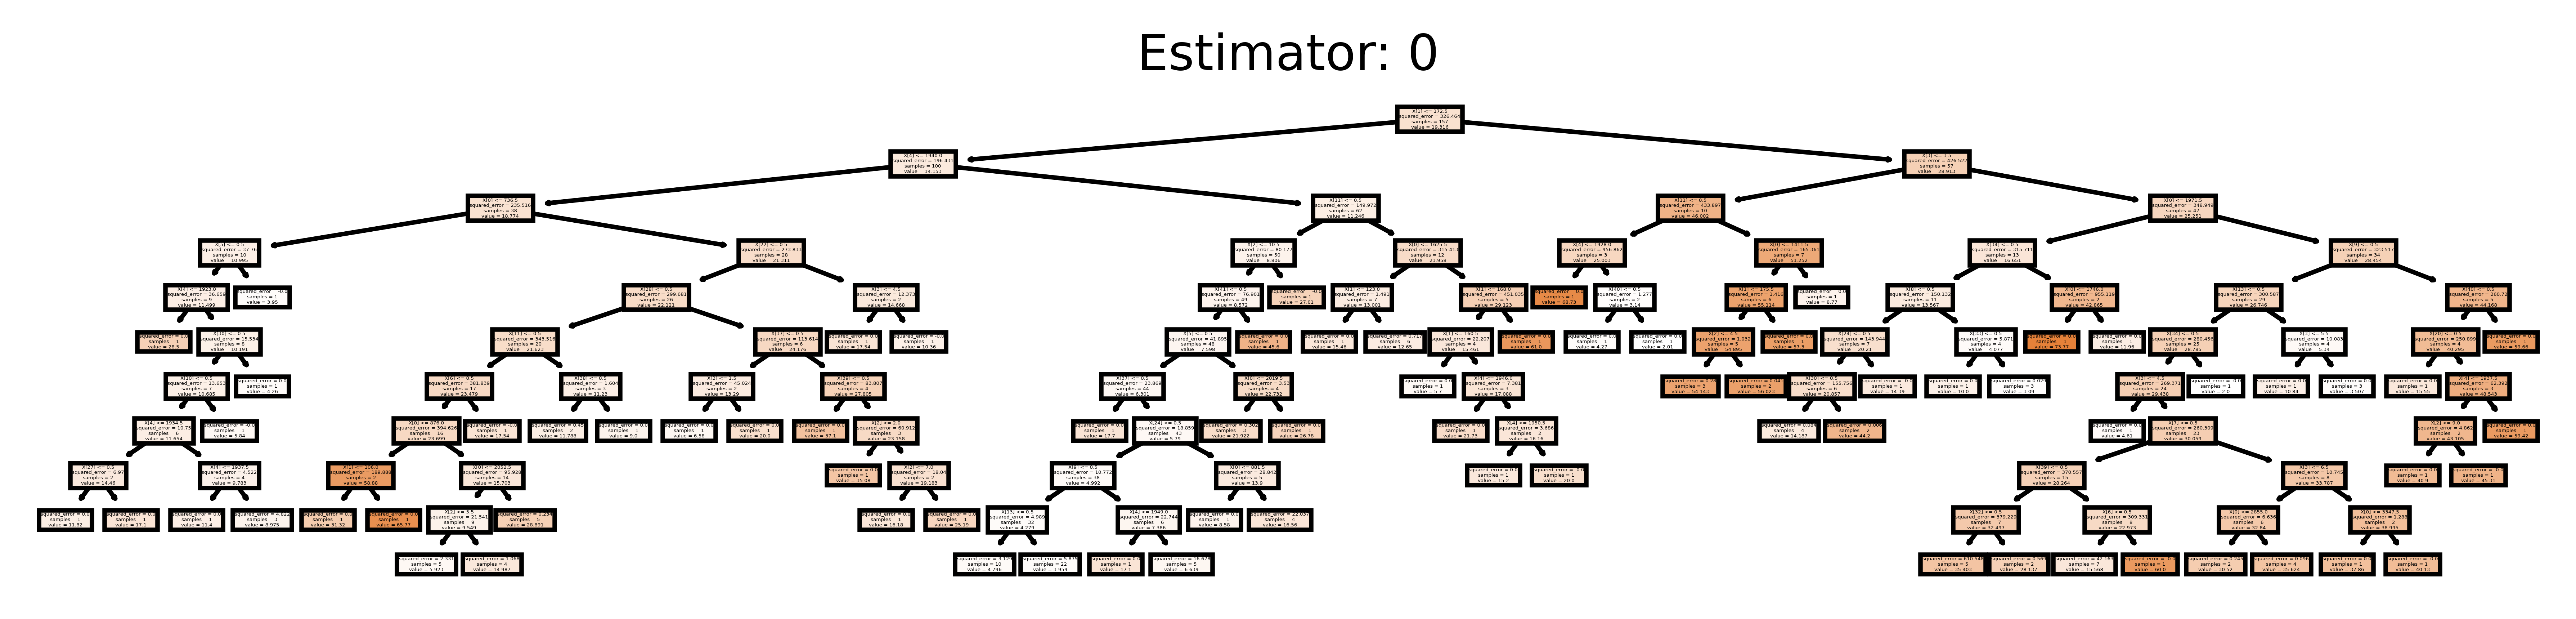

In [ ]:
from sklearn import tree
from dtreeviz.trees import dtreeviz 
# This may not the best way to view each estimator as it is small
fn=X.dtype.names
cn=Y.dtype.names
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,2), dpi=900)

tree.plot_tree(t_rf.estimators_[0],
                   feature_names = fn, 
                   class_names=cn,
                   filled = True)

axes.set_title('Estimator: ' + str(0), fontsize = 11)
viz = dtreeviz(t_rf.estimators_[0], X, Y, feature_names=fn, target_name="Target")
print(viz)
fig.savefig('rf_5trees.png')

Fitted vs Actual plot (Test set)

In [ ]:
# Visualising the Random Forest Regression results
predictions = t_rf.predict(X_T)
mae = np.round(abs(Y_T - predictions))
d = {'label': Y_T, 'prediction': predictions, 'mae': mae}
plot = pd.DataFrame(data = d)
# plot absolute settings
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("ticks")

points = plt.scatter(d["label"], d["prediction"], s=50, c=d["mae"], cmap="crest")
plt.colorbar(points)
plt.xlim(0, 67)
plt.ylim(0, 67)

sns.regplot(
    x="label", y="prediction", data=plot, scatter = False, color='g')
 

NameError: ignored

Absolute error in the test set plot

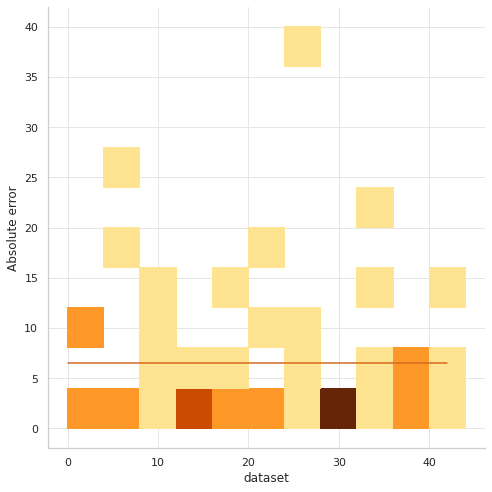

In [ ]:
# Visualising the Random Forest Regression results
n = X_T.shape[0]

sns.set_style("whitegrid", {"grid.color": ".9"})
numbers = np.array(list(range(0,int(n),+1)))

value = np.round(abs(Y_T - predictions))
d = {'Absolute error': value, 'dataset': numbers}
plot = pd.DataFrame(data = d)

sns.displot(data = plot, x="dataset", y="Absolute error", height=7,
    aspect=1, binwidth=(4, 4), cmap="YlOrBr")

sns.lineplot(data = plot, x="dataset", y=MAE, color = 'chocolate')

Feature importance

In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.2 MB/s 


In [ ]:
import shap
from scipy.special import softmax
from sklearn.feature_selection import SelectFwe, chi2

def print_feature_importances_random_forest(random_forest_model):
    
    '''
    Prints the feature importances of a Random Forest model in an ordered way.
    random_forest_model -> The sklearn.ensemble.RandomForestRegressor or RandomForestClassifier trained model
    '''
    
    # Fetch the feature importances and feature names
    importances = t_rf.feature_importances_
    features = headers
    
    # Organize them in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f}")

def print_feature_importances_shap_values(shap_values, features):
    
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''

    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
        
    # Calculates the normalized version
    importances_norm = softmax(importances)

    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}

    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}

    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [ ]:
import shap
# Fits the explainer
explainer = shap.Explainer(t_rf, feature_names= headers)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X)

In [ ]:
# Prints the feature importances
print_feature_importances_random_forest(t_rf)

AREA_F -> 0.1776
VOL -> 0.1346
YOC -> 0.1174
APT_NUM -> 0.0690
ST_NUM -> 0.0689
ZIPCODE_8052 -> 0.0491
KREIS_6 -> 0.0425
ZIPCODE_8002 -> 0.0375
ZIPCODE_8057 -> 0.0340
KREIS_11 -> 0.0308
ZIPCODE_8032 -> 0.0208
POC_1946 - 1960 -> 0.0203
KREIS_9 -> 0.0201
ZIPCODE_8055 -> 0.0169
ZIPCODE_8048 -> 0.0166
POC_1919 - 1945 -> 0.0157
KREIS_7 -> 0.0151
KREIS_2 -> 0.0099
ZIPCODE_8004 -> 0.0092
ROOF_P -> 0.0088
KREIS_4 -> 0.0081
ZIPCODE_8053 -> 0.0075
ZIPCODE_8051 -> 0.0073
KREIS_10 -> 0.0062
KREIS_12 -> 0.0062
ROOF_F -> 0.0058
POC_1961 - 1970 -> 0.0057
ZIPCODE_8049 -> 0.0050
ZIPCODE_8038 -> 0.0049
POC_1900 - 1919 -> 0.0043
ZIPCODE_8046 -> 0.0040
ROOF_M -> 0.0036
KREIS_3 -> 0.0034
ZIPCODE_8044 -> 0.0031
ZIPCODE_8050 -> 0.0030
ROOF_O -> 0.0026
ZIPCODE_8047 -> 0.0018
ZIPCODE_8006 -> 0.0010
ZIPCODE_8008 -> 0.0007
ZIPCODE_8003 -> 0.0004
KREIS_8 -> 0.0004
POC_1971 - 1980 -> 0.0001
ZIPCODE_8045 -> 0.0001


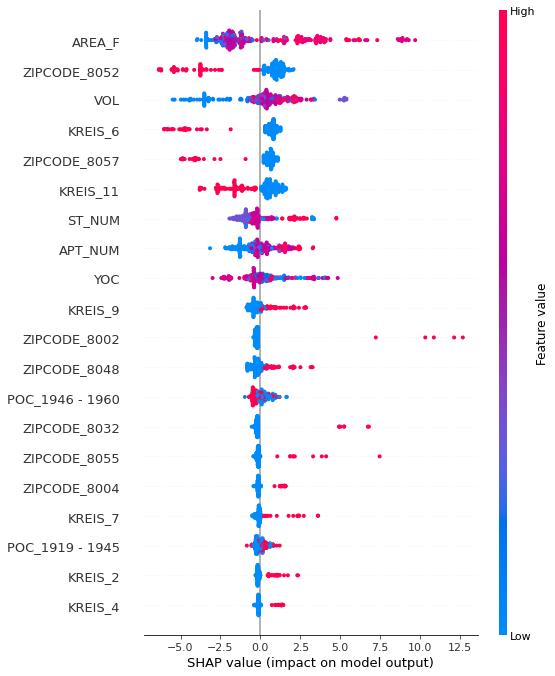

In [ ]:
shap.summary_plot(shap_values, feature_names = headers,show=False)
import matplotlib.pyplot as pl
fig = pl.gcf()
fig.savefig('wood_rf_imp.png')